In [1]:
# External Libraries
import skimage.io
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans

# Builtin libraries
import os
import math
import json
import time
import pathlib
import zipfile
import itertools
import functools
import collections
import concurrent.futures
from pprint import pprint
from threading import RLock

## nonogramize the image using PIL (old)

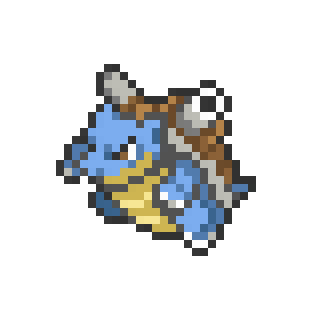

In [2]:
im = Image.open("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")

im = im.convert("RGBA", palette=Image.ADAPTIVE, colors=256)
# im = im.convert('P', palette=Image.WEB, colors=12)
# im = im.convert('P', dither=Image.NONE, palette=Image.ADAPTIVE, colors=5)
# im = im.convert("RGBA", palette=Image.ADAPTIVE, colors=256)
pix = im.load()
W, H = im.size

# Resize to view
ratio = math.ceil(300/W)
im.resize([W * ratio, H * ratio], resample=Image.NEAREST)

#### Find start and end row/col

In [3]:
# First and Last Row/Column
f_row = l_row = f_col = l_col = None
for y in range(H):
    for x in range(W):
        if pix[x, y] == (255, 255, 255, 0): continue
        if not f_row: f_row = y
        l_row = y
        if not f_col or x < f_col: f_col = x
        if not l_col or x > l_col: l_col = x
print(f_row, l_row, f_col, l_col)

8 31 7 31


In [4]:
# Count color freq
rows_count = {}
for y in range(f_row, l_row + 1):
    count = []
    row = []
    for x in range(f_col, l_col + 1):
        p = pix[x, y]
        row.append("#%02x%02x%02x%02x"%(p[0], p[1], p[2], p[3]))
    for k, grp in itertools.groupby(row):
        count.append((k, len(list(grp))))
    rows_count[y] = count
    
for k, count in rows_count.items():
    rows_count[k] = list(filter(lambda x: x[0] != "#ffffff00", count))
pprint(rows_count, compact=True)

{8: [('#363636ff', 1), ('#313131ff', 1)],
 9: [('#363636ff', 1), ('#797979ff', 1), ('#bbbbb4ff', 1), ('#333333ff', 1)],
 10: [('#363636ff', 1), ('#babab2ff', 1), ('#bdbdb5ff', 2), ('#333333ff', 1),
      ('#363636ff', 1), ('#313131ff', 1)],
 11: [('#353535ff', 1), ('#797979ff', 1), ('#bbbbb4ff', 1), ('#bdbdb5ff', 2),
      ('#333333ff', 1), ('#353535ff', 1), ('#313131ff', 3), ('#fbfbfbff', 1),
      ('#ffffffff', 1), ('#343434ff', 1)],
 12: [('#363636ff', 1), ('#797979ff', 1), ('#bbbbb4ff', 1), ('#8c643aff', 1),
      ('#6b4a29ff', 1), ('#313130ff', 1), ('#313131ff', 2), ('#b28249ff', 1),
      ('#6c4a29ff', 1), ('#525151ff', 1), ('#fcfcfcff', 1), ('#343434ff', 1),
      ('#313131ff', 1), ('#fbfbfbff', 1), ('#343434ff', 1)],
 13: [('#353535ff', 1), ('#79abecff', 1), ('#323233ff', 1), ('#8a6238ff', 1),
      ('#6b4a29ff', 1), ('#b38349ff', 1), ('#b5844aff', 1), ('#6c4a29ff', 1),
      ('#b38349ff', 1), ('#6c4a29ff', 1), ('#525151ff', 1), ('#bbbbb3ff', 1),
      ('#fdfdfdff', 1), ('#3434

## nonogramize the image using skimage and np

In [36]:
def reduce_color_palette(im, n_colors=8, n_init=512, max_iter=1000, tol=0.00001):
    """
    Reduce color palette using K-means
    n_colors: number of colors in the final image
    """
    im = np.copy(im)
    # Transform image to array
    w,h,z = im.shape
    im = im.reshape(w*h,z)
    
    # Train model
    kmeans = KMeans(n_clusters=n_colors, 
                    n_init=n_init, 
                    max_iter=max_iter, 
                    tol=tol,
                    random_state=0,
                   ).fit(im)
    
    # find out which cluster each pixel belongs to.
    labels = kmeans.predict(im)
    
    # the cluster centroids is our color palette
    identified_palette = np.array(kmeans.cluster_centers_).astype(int)
    
    # recolor the entire image
    recolored_img = np.copy(im)
    for index in range(len(im)):
        im[index] = identified_palette[labels[index]]
    
    # reshape for display
    im = im.reshape(w,h,z)
    
    return im

def get_colored_pixel_rectangle(im):
    """
    return First Row, Last Row, First Column, Last Column as a tuple
    """
    f_row = l_row = f_col = l_col = None
    for r, row in enumerate(im):
        for c, p in enumerate(row):
            pixel = "#" + "".join(f"{c:02x}" for c in p)
            if pixel[1:6:2] == "fff": continue
            if pixel[1:6:2] == "000": continue
            if not f_row: f_row = r
            l_row = r
            if not f_col or c < f_col: f_col = c
            if not l_col or c > l_col: l_col = c
    return (f_row, l_row, f_col, l_col)

def get_row_counts(im, dim):
    """
    return the the groupby() of rows as dictionary
    """
    f_row, l_row, *_ = dim
    rows_count = {}
    for r in range(f_row, l_row + 1):
        count = []
        row =["#" + "".join(f"{c:02x}" for c in p) for p in im[r,:]]
        for k, grp in itertools.groupby(row):
            count.append((k, len(list(grp))))
        rows_count[r] = count

    for k, count in rows_count.items():
        rows_count[k] = list(filter(lambda x:x[0][1:6:2] not in ("fff", "000"), 
                                    count))
    return rows_count

def get_col_counts(im, dim):
    """
    return the the groupby() of cols as dictionary
    """
    *_, f_col, l_col = dim
    cols_count = {}
    for c in range(f_col, l_col + 1):
        count = []
        col =["#" + "".join(f"{c:02x}" for c in p) for p in im[:,c]]
        for k, grp in itertools.groupby(col):
            count.append((k, len(list(grp))))
        cols_count[c] = count

    for k, count in cols_count.items():
        cols_count[k] = list(filter(lambda x:x[0][1:6:2] not in ("fff", "000"), 
                                    count,))
    return cols_count

def generate_nonogram_by_size(image_path, verbose=False):
    """
    Creating nonogram for 1 image
    """
    image = skimage.io.imread(image_path)[:,:,:-1] # to Exclude alpha
    nonogram_by_ncolor = {}
    for n_color in (5, 8, 11):
        im = reduce_color_palette(image, n_colors=n_color, n_init=256, max_iter=500, tol=1e-05)
        dim = get_colored_pixel_rectangle(im)
        rows_count = get_row_counts(im, dim)
        cols_count = get_col_counts(im, dim)
        nonogram_by_ncolor[n_color] = [rows_count, cols_count]
    
#     with lock:
#         nonogram[image_path.rsplit("/",1)[-1]]=nonogram_by_ncolor
    if verbose:
        print(f"Done with {image_path}")
    return nonogram_by_ncolor


def multithread(image_paths=[], no_threads=16, verbose=False):
    """
    Multithreading creating nonogram
    """
    nonogram = {}
    lock = RLock()
    with concurrent.futures.ThreadPoolExecutor(max_workers=no_threads) as executor:
        partial_func = functools.partial(generate_nonogram_by_size, nonogram=nonogram, lock=lock, verbose=verbose)
        executor.map(partial_func, image_paths)
    return nonogram

# Test Run

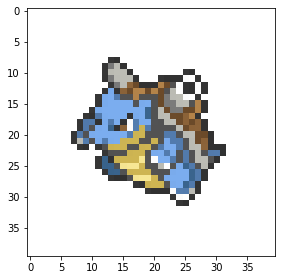

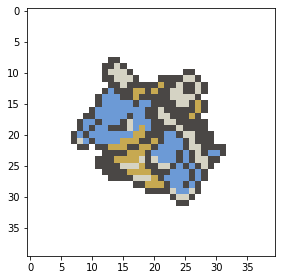

{5: [{8: [('#49433d', 2)],
   9: [('#49433d', 1), ('#52759c', 1), ('#c6b680', 1), ('#49433d', 1)],
   10: [('#49433d', 1), ('#c6b680', 3), ('#49433d', 1), ('#49433d', 2)],
   11: [('#49433d', 1),
    ('#52759c', 1),
    ('#c6b680', 3),
    ('#49433d', 1),
    ('#49433d', 4),
    ('#49433d', 1)],
   12: [('#49433d', 1),
    ('#52759c', 1),
    ('#c6b680', 1),
    ('#49433d', 5),
    ('#c6b680', 1),
    ('#49433d', 2),
    ('#49433d', 2),
    ('#49433d', 1)],
   13: [('#49433d', 1),
    ('#7aaced', 1),
    ('#49433d', 3),
    ('#c6b680', 2),
    ('#49433d', 1),
    ('#c6b680', 1),
    ('#49433d', 2),
    ('#c6b680', 1),
    ('#49433d', 2),
    ('#49433d', 1)],
   14: [('#49433d', 1),
    ('#7aaced', 2),
    ('#52759c', 1),
    ('#49433d', 2),
    ('#c6b680', 1),
    ('#49433d', 4),
    ('#52759c', 1),
    ('#c6b680', 2),
    ('#49433d', 1)],
   15: [('#49433d', 1),
    ('#7aaced', 5),
    ('#49433d', 1),
    ('#7aaced', 2),
    ('#49433d', 2),
    ('#52759c', 2),
    ('#c6b680', 2),
    

In [38]:
im = skimage.io.imread("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")
skimage.io.imshow(im)
skimage.io.show()
im = reduce_color_palette(im[:,:,:], 5) # im[:,:,:-1] to Exclude alpha
skimage.io.imshow(im)
skimage.io.show()
generate_nonogram_by_size("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")

# Actual Run

In [10]:
db_path = "../DataScraping/data/pokemon_sprites_bulbapedia/"
nonogram = {}
for file in os.listdir(db_path):
    nonogram_by_ncolor = generate_nonogram_by_size(db_path + file, True)
    nonogram[file] = nonogram_by_ncolor
print(f"Finish nonogramize all sprites")

Done with ../DataScraping/data/pokemon_sprites_bulbapedia/001_Bulbasaur.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/002_Ivysaur.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/003_Venusaur.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/004_Charmander.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/005_Charmeleon.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/006_Charizard.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/007_Squirtle.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/008_Wartortle.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/010_Caterpie.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/011_Metapod.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/012_Butterfree.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/013_Weedle.png
Done with ../DataSc

c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/019_1_Rattata.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/019_Rattata.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/020_1_Raticate.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/020_Raticate.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/021_Spearow.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/022_Fearow.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/023_Ekans.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/024_Arbok.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/025_Pikachu.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/026_1_Raichu.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/026_Raichu.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/027_1_Sandshrew.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/027_Sandshrew.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/028_1_Sandslash.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/028_Sandslash.png
Done with ../DataScraping/d

c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/037_1_Vulpix.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/037_Vulpix.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/038_1_Ninetales.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/038_Ninetales.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/039_Jigglypuff.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/040_Wigglytuff.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/041_Zubat.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/042_Golbat.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/043_Oddish.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/044_Gloom.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/045_Vileplume.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/046_Paras.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/047_Parasect.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/048_Venonat.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/049_Venomoth.png
Done with ../DataScraping/data

c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/052_1_Meowth.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/052_2_Meowth.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/052_Meowth.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/053_1_Persian.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/053_Persian.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/054_Psyduck.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/055_Golduck.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/056_Mankey.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/057_Primeape.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/058_Growlithe.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/059_Arcanine.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/060_Poliwag.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/061_Poliwhirl.png
Done with ../DataScraping/data

c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/074_1_Geodude.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/074_Geodude.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/075_1_Graveler.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/075_Graveler.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/076_1_Golem.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/076_Golem.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/077_1_Ponyta.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/077_Ponyta.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/078_1_Rapidash.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/078_Rapidash.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/079_1_Slowpoke.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/079_Slowpoke.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/080_Slowbro.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/081_Magnemite.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/082_Magneton.png
Done with ../DataScraping

c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/208_Steelix.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/209_Snubbull.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/210_Granbull.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/211_Qwilfish.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/212_Scizor.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/213_Shuckle.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/214_Heracross.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/215_Sneasel.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/216_Teddiursa.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/217_Ursaring.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/218_Slugma.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/219_Magcargo.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/220_Swinub.png
Done with ../DataScraping/data/p

c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/653_Fennekin.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/654_Braixen.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/655_Delphox.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/656_Froakie.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/657_Frogadier.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/658_Greninja.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/659_Bunnelby.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/660_Diggersby.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/661_Fletchling.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/662_Fletchinder.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/663_Talonflame.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/664_Scatterbug.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/665_Spewpa.png
Done with ../DataSc

c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/678_Meowstic.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/679_Honedge.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/680_Doublade.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/681_Aegislash.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/682_Spritzee.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/683_Aromatisse.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/684_Swirlix.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/685_Slurpuff.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/686_Inkay.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/687_Malamar.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/688_Binacle.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/689_Barbaracle.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/690_Skrelp.png
Done with ../DataScraping/dat

c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/725_Litten.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/726_Torracat.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/727_Incineroar.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/728_Popplio.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/729_Brionne.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/730_Primarina.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/731_Pikipek.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/732_Trumbeak.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/733_Toucannon.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/734_Yungoos.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/735_Gumshoos.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/736_Grubbin.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/737_Charjabug.png
Done with ../DataScraping/d

c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/742_Cutiefly.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/743_Ribombee.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/744_Rockruff.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/745_Lycanroc.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/746_Wishiwashi.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/747_Mareanie.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/748_Toxapex.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/749_Mudbray.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/750_Mudsdale.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/751_Dewpider.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/752_Araquanid.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/753_Fomantis.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/754_Lurantis.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/755_Morelull.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/756_Shiinotic.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/757_Salandit.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/758_Salazzle.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/759_Stufful.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/760_Bewear.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/761_Bounsweet.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/762_Steenee.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/763_Tsareena.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/764_Comfey.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/765_Oranguru.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/766_Passimian.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/767_Wimpod.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/768_Golisopod.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/769_Sandygast.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/770_Palossand.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/771_Pyukumuku.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/772_Type%3A%20Null.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/773_Silvally.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/774_Minior.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/775_Komala.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/776_Turtonator.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/777_Togedemaru.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/778_Mimikyu.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/779_Bruxish.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/780_Drampa.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/781_Dhelmise.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/782_Jangmo-o.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/783_Hakamo-o.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/784_Kommo-o.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/785_Tapu%20Koko.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/786_Tapu%20Lele.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/787_Tapu%20Bulu.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/788_Tapu%20Fini.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/789_Cosmog.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/790_Cosmoem.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/791_Solgaleo.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/792_Lunala.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/793_Nihilego.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/794_Buzzwole.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/795_Pheromosa.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/796_Xurkitree.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/797_Celesteela.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/798_Kartana.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/799_Guzzlord.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/800_Necrozma.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/801_Magearna.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/802_Marshadow.png


c:\users\trung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.


Done with ../DataScraping/data/pokemon_sprites_bulbapedia/803_Poipole.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/804_Naganadel.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/805_Stakataka.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/806_Blacephalon.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/807_Zeraora.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/808_Meltan.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/809_Melmetal.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/810_Grookey.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/811_Thwackey.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/812_Rillaboom.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/813_Scorbunny.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/814_Raboot.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/815_Cinderace.png
Done with ../DataScrapin

In [12]:
with open("./data/info.json", "w") as f:
    json.dump(nonogram, f)

In [13]:
pprint(nonogram, width=120, compact=True, depth=2)

{'001_Bulbasaur.png': {5: [...], 8: [...], 11: [...]},
 '002_Ivysaur.png': {5: [...], 8: [...], 11: [...]},
 '003_Venusaur.png': {5: [...], 8: [...], 11: [...]},
 '004_Charmander.png': {5: [...], 8: [...], 11: [...]},
 '005_Charmeleon.png': {5: [...], 8: [...], 11: [...]},
 '006_Charizard.png': {5: [...], 8: [...], 11: [...]},
 '007_Squirtle.png': {5: [...], 8: [...], 11: [...]},
 '008_Wartortle.png': {5: [...], 8: [...], 11: [...]},
 '009_Blastoise.png': {5: [...], 8: [...], 11: [...]},
 '010_Caterpie.png': {5: [...], 8: [...], 11: [...]},
 '011_Metapod.png': {5: [...], 8: [...], 11: [...]},
 '012_Butterfree.png': {5: [...], 8: [...], 11: [...]},
 '013_Weedle.png': {5: [...], 8: [...], 11: [...]},
 '014_Kakuna.png': {5: [...], 8: [...], 11: [...]},
 '015_Beedrill.png': {5: [...], 8: [...], 11: [...]},
 '016_Pidgey.png': {5: [...], 8: [...], 11: [...]},
 '017_Pidgeotto.png': {5: [...], 8: [...], 11: [...]},
 '018_Pidgeot.png': {5: [...], 8: [...], 11: [...]},
 '019_1_Rattata.png': {5: 